In [113]:
import importlib, benchmark_PI
importlib.reload(benchmark_PI)
from benchmark_PI import benchmark_PI
import importlib, deep_lab
importlib.reload(deep_lab)
from deep_lab import DeepLab

results = benchmark_PI(model="models/land-seg.pt", data="dataset/landslide_dataset_1000/data.yml", imgsz=512, format='deeplab', device ='cpu', limit = 10)
print(results)

Usando modelo DeepLab para inferência

Procurando o modelo DeepLab em models/land-seg.pth
Modelo pronto para inferência ✅
Modelo DeepLab carregado com sucesso

Aquecendo o modelo

Aquecimento concluído

Testando com 10 imagens!
[val] falhou: AttributeError: 'DeepLab' object has no attribute 'val'
[val] sem métricas (checar data.yaml, labels e compatibilidade da task)
[{'Format': 'DeepLab', 'Status❔': '✅', 'Size (MB)': 19.6, 'Inference Time(ms/im)': 2.88, 'Avarage Processing Time (ms/im)': 2921.35, 'FPS': 0.34, 'Throughput (img/s)': 0.34, 'cpu_proc_avg (%)': 375.83, 'ram_proc_mb (MB)': 2160.9, 'gpu_avg (%)': nan, 'power_avg (W)': nan, 'ram_total_mb (MB)': nan, 'precision': 0.8746, 'recall': 0.8941, 'iou': 0.7919, 'f1': 0.8835, 'accuracy': 0.9676}]


In [38]:
import torch
import torchvision.models.segmentation as models
import torch.nn as nn

path = "models/landslide1000_200_adam.pth"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# --- carregar state_dict de forma segura ---
try:
    state_dict = torch.load(path, map_location=device, weights_only=True)
except TypeError:
    state_dict = torch.load(path, map_location=device)

# alguns treinos salvam como dicts aninhados
for k in ("state_dict", "model_state_dict"):
    if isinstance(state_dict, dict) and k in state_dict:
        state_dict = state_dict[k]

# remover 'module.' (DataParallel)
if len(state_dict) and next(iter(state_dict)).startswith("module."):
    state_dict = {k.replace("module.", "", 1): v for k, v in state_dict.items()}

# --- inferir num_classes do checkpoint (confirmado como 2 no seu output) ---
num_classes_sd = state_dict["classifier.4.weight"].shape[0]  # == 2

# --- instanciar o modelo correto, sem baixar pesos e sem aux head ---
# Em versões mais novas do torchvision você pode passar num_classes diretamente:
try:
    model = models.deeplabv3_resnet101(weights=None, weights_backbone=None,
                                       aux_loss=False, num_classes=num_classes_sd)
except TypeError:
    # fallback universal: substituir a última conv manualmente
    model = models.deeplabv3_resnet101(weights=None, weights_backbone=None, aux_loss=False)
    model.classifier[4] = nn.Conv2d(256, num_classes_sd, kernel_size=1, bias=True)

# --- carregar pesos com shapes compatíveis ---
missing, unexpected = model.load_state_dict(state_dict, strict=True)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

model = model.to(device).eval()
print("Modelo pronto para inferência ✅")


Missing keys: []
Unexpected keys: []
Modelo pronto para inferência ✅


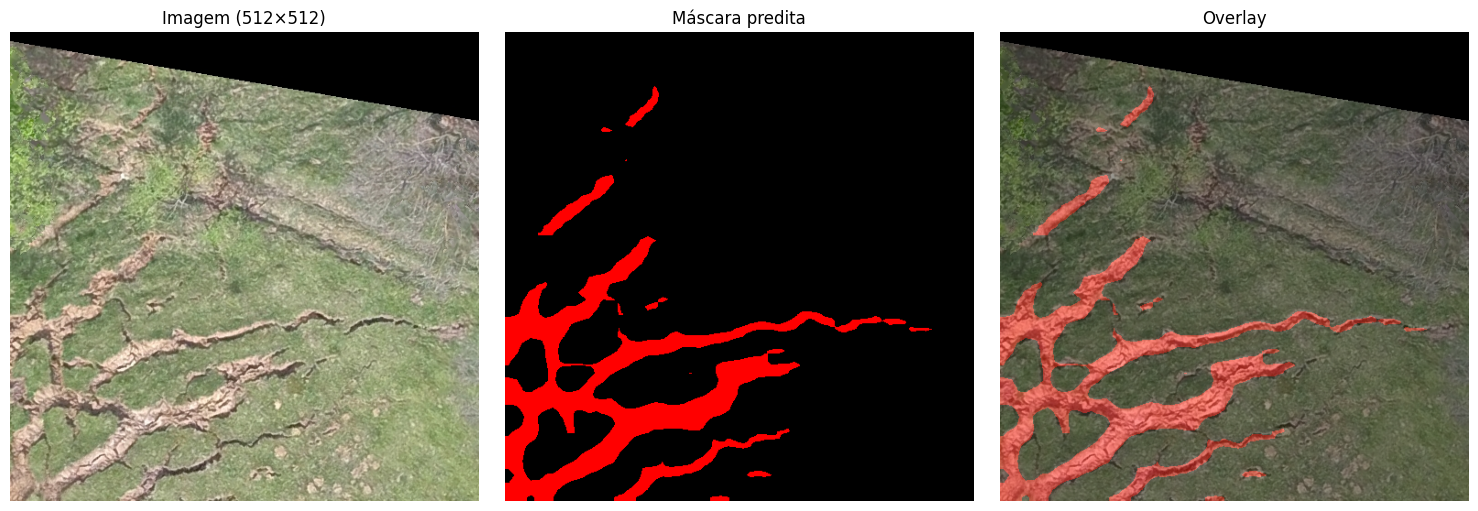

In [48]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1) Transform fixo em 512x512
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),     # ou mantenha o tamanho nativo e depois faça interpolate nos logits
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# 2) Carregar imagem original
img = cv2.imread("dataset/landslide_dataset_1000/valid/images/000000000017.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 3) Preparar tensor
input_tensor = transform(img_rgb).unsqueeze(0).to(device)

# 4) Inferência
with torch.no_grad():
    out = model(input_tensor)["out"][0]            # [C, H, W] = [num_classes, 512, 512]
    prediction = out.argmax(0).cpu().numpy()       # [512, 512]

# 5) Paleta e máscara
colors = np.array([[0,0,0], [255,0,0]], dtype=np.uint8)  # 0=bg, 1=deslizamento
mask = colors[prediction]                                # [512,512,3]

# 6) Como a img original pode não ser 512x512, garanta que tenha 512x512 pro overlay:
img_512 = cv2.resize(img_rgb, (512, 512), interpolation=cv2.INTER_LINEAR)

# 7) Overlay
overlay = (0.6 * img_512 + 0.4 * mask).astype(np.uint8)

# 8) Plot
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(img_512); ax[0].set_title("Imagem (512×512)"); ax[0].axis("off")
ax[1].imshow(mask);    ax[1].set_title("Máscara predita");   ax[1].axis("off")
ax[2].imshow(overlay); ax[2].set_title("Overlay");           ax[2].axis("off")
plt.tight_layout(); plt.show()


Modelo pronto para inferência ✅


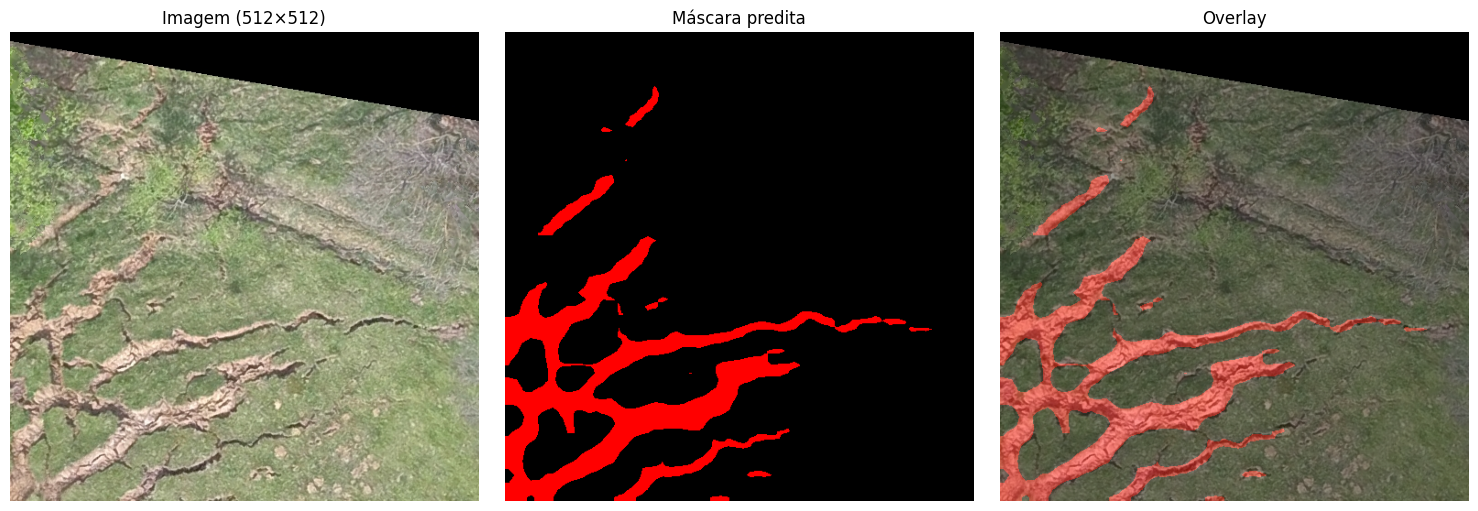

-2.6660070419311523


In [91]:
import importlib, deep_lab
importlib.reload(deep_lab)
from deep_lab import DeepLab

img_path = "dataset/landslide_dataset_1000/valid/images/000000000017.jpg"

model = DeepLab(2, model_path="models/landslide1000_200_adam.pth")
prediction, inf_time = model.predict(img_path)
model.plot()

print(inf_time)

In [60]:
def compute_metrics(gt_mask, pred_mask):
    tp = np.logical_and(gt_mask, pred_mask).sum()
    fp = np.logical_and(~gt_mask, pred_mask).sum()
    fn = np.logical_and(gt_mask, ~pred_mask).sum()
    tn = np.logical_and(~gt_mask, ~pred_mask).sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    return precision, recall, iou, f1, accuracy

In [64]:
gt = cv2.imread("dataset/landslide_dataset_1000/valid/masks/000000000017.png", cv2.IMREAD_GRAYSCALE) > 0
print(compute_metrics(gt, prediction==1))

(0.8608823632477135, 0.8577264157530898, 0.7533116644180057, 0.8593014918064324, 0.9693107604980469)



image 1/1 /home/joaorrafa/Documents/DRONE_RESEARCH/yolo/comparing_YOLO_jetson/dataset/landslide_dataset_1000/valid/images/000000000017.jpg: 512x512 14 lands, 176.7ms
Speed: 1.1ms preprocess, 176.7ms inference, 9.2ms postprocess per image at shape (1, 3, 512, 512)


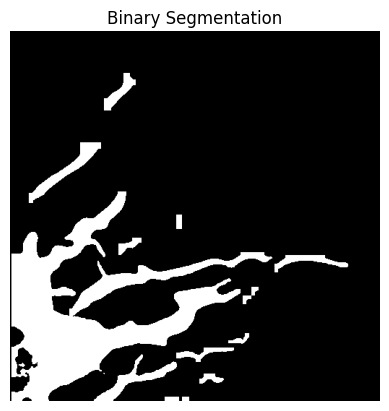

(0.7514479291880669, 0.9603379652258921, 0.7288288288288288, 0.8431474726420011, 0.9609603881835938)


In [92]:
from ultralytics import YOLO

model = YOLO("models/land-seg.pt")  # carregar modelo pré-treinado

results = model(img_path)
if results[0].masks is None:
    raise ValueError("Este modelo não tem saída de segmentação!")

# masks shape: (N, H, W)
masks = results[0].masks.data.cpu().numpy()

# juntar todas as máscaras numa só
binary_mask = np.any(masks > 0.5, axis=0).astype(np.uint8)  # [H,W] com 0/1

# converter para imagem branca/preta (0 ou 255)
binary_img = binary_mask * 255

# salvar ou plotar
cv2.imwrite("binary_mask.png", binary_img)

plt.imshow(binary_img, cmap="gray")
plt.title("Binary Segmentation")
plt.axis("off")
plt.show()

print(compute_metrics(gt, binary_img))

In [96]:
from collections import defaultdict
metrics_per_class = defaultdict(lambda: {"iou": [], "precision": [], "recall": [], "f1": [], "accuracy": []})
print(metrics_per_class)

defaultdict(<function <lambda> at 0x7ff927292ee0>, {})
